In [1]:
from dataclasses import dataclass
import typing as t
from enum import Enum
import os
from dotenv import load_dotenv

import torch
from torch import nn
import numpy as np
from torchvision.utils import make_grid

from model import VQVAE, VQVAETrainer, QuantizationLoss
from data import CIFAR10DataLoader, ImageDatasetTransforms
from utils import plot_images_in_grid, display_tensor_as_image

/Users/danielvaroli/opt/anaconda3/envs/vq-vae-pt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device_id = "mps:0"
device = torch.device(device_id)
seed = 1000

if seed is not None:
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
cifar10 = CIFAR10DataLoader(
    train=True, 
    shuffle=True, 
    batch_size=1,
    transforms=ImageDatasetTransforms.HALF_RGB.value
)

Files already downloaded and verified


In [78]:
model = VQVAE(3, n_embeddings=10)
state_dict = torch.load("vqvae-weights_975af2f2-8050-4bec-bbe6-39c895c1814d.pt")
model.load_state_dict(state_dict)
model.eval();

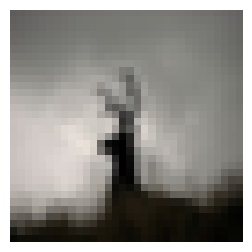

In [79]:
reference_image = next(iter(cifar10))[0]
display_tensor_as_image(reference_image[0] + 0.5, figsize=(3, 5))

In [80]:
with torch.no_grad():
    reconstructions = model(reference_image)

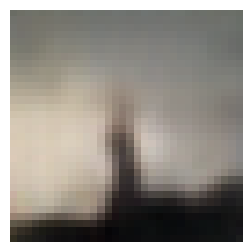

In [81]:
display_tensor_as_image(reconstructions[0] + 0.5, figsize=(3, 5))

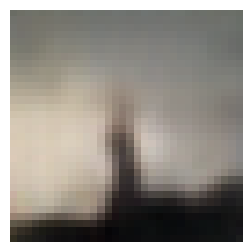

In [82]:
with torch.no_grad():
    pre_quantized = model.encoder.forward(reference_image)
    pre_quantized = model.pre_quantizer_conv.forward(pre_quantized)
    pre_quantized = pre_quantized.permute(0, 2, 3, 1).contiguous()
    quantized, _= model.quantizer.forward(pre_quantized)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()
    quantized_shape = quantized.shape
    step_wise_reconstruction = model.decoder.forward(quantized)

display_tensor_as_image(step_wise_reconstruction[0] + 0.5, figsize=(3, 5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


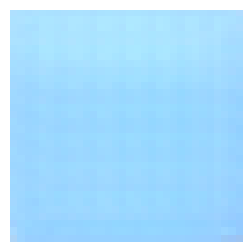

In [90]:
# now lets take the first code vector from the codebook replace all vectors in the reference encoding]
with torch.no_grad():
    quantized_copy = torch.clone(quantized)
    code_index = 6
    code = model.quantizer.codebook.weight.data[code_index, :].unsqueeze(0)
    quantized_single_vector = code.repeat(1, 8, 8, 1).permute(0, 3, 1, 2)
    test_reconstruction = model.decoder.forward(quantized_single_vector)
display_tensor_as_image(test_reconstruction[0] + 0.6, figsize=(3, 5))